## Introduction

This project conducts a network analysis of data consisting of 'circles' (or 'friends lists') from Facebook, collected from survey participants. The data consists of nodes or ids of participants that are associated (participants connected on each row between start_node and end_node).

Dataset is from Stanford Facebook Dataset
https://snap.stanford.edu/data/ego-Facebook.html

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import nxviz as nv

%matplotlib inline

C:\Users\Tobias\anaconda3\lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


## Network graph

In [2]:
facebook = pd.read_csv(
    #"data/facebook_combined.txt.gz",
    "http://snap.stanford.edu/data/facebook_combined.txt.gz",
    compression="gzip",
    sep=" ",
    names=["start_node", "end_node"],
)
facebook.head()

,start_node,end_node
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


Let us create a network graph to get an overview of the data.

In [3]:
G = nx.from_pandas_edgelist(facebook, "start_node", "end_node")

We visualize the network of the facebook nodes and edges. It is quite hard to discern much pattern in this graph so we will continue to examine more details to get a clearer picture.

(-0.6526628029346465,
 0.7188801062107085,
 -1.185868907868862,
 0.9560496696829797)

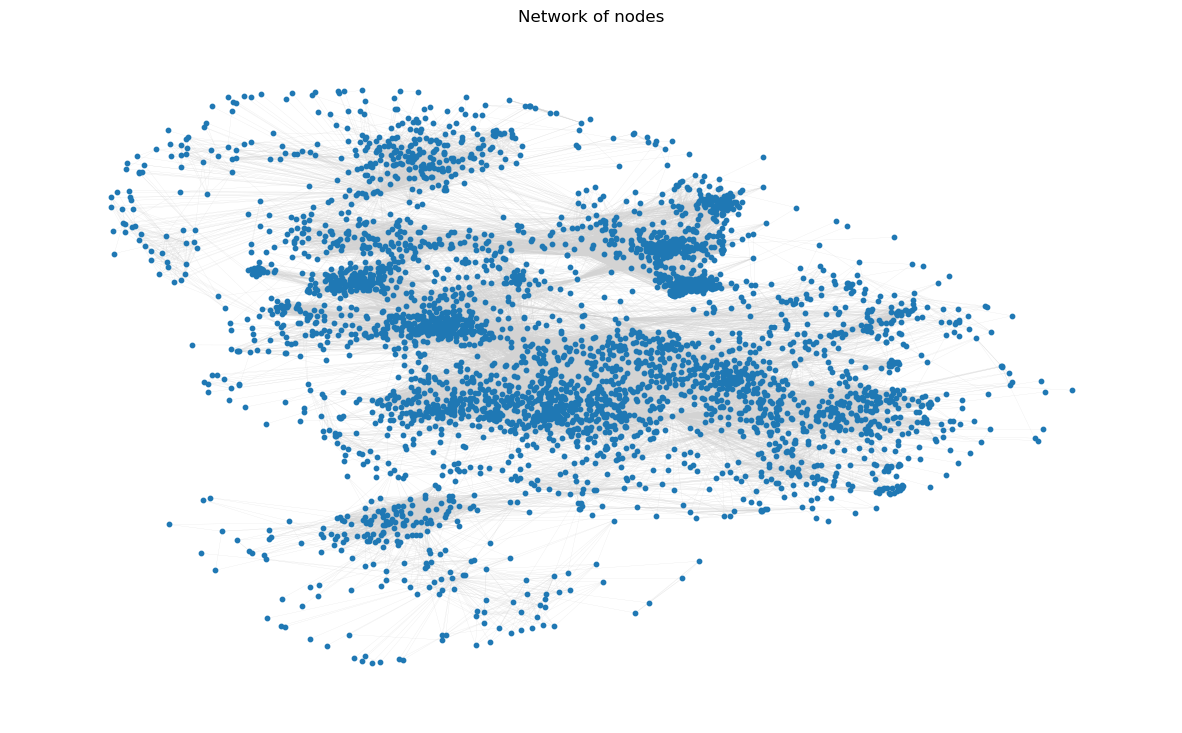

In [4]:
pos = nx.spring_layout(G, iterations=15, seed=42)
fig, ax = plt.subplots(figsize=(15, 9))
plt.title("Network of nodes")
nx.draw_networkx(
    G, 
    pos=pos, 
    node_size=10,
    with_labels=False,
    edge_color='lightgrey',
    width=0.10
)
plt.axis("off")

While the network shows the overall topology of the friend groups, it might be informative to display the relationship structure in another way to gain insights into possible concentrated clusters of relationships. As the dataset is large we decide to show a subset of the first 1,000 associations. Nodes are shown along the circumference as blue dots and associations as dark lines. It is clear that some nodes have a much higher degree (number of relations) than others.

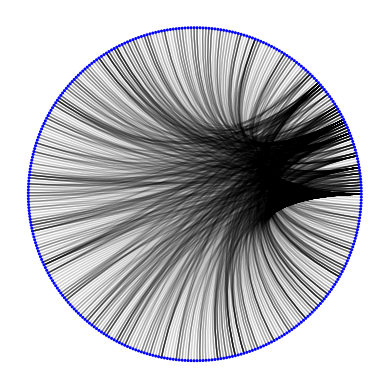

In [5]:
G_subset = nx.from_pandas_edgelist(facebook.iloc[:1000], "start_node", "end_node")
ax = nv.circos(G_subset)


## Network structure

With the network graphs, let us examine the network topology through various metrics.

In [6]:
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

In [7]:
# Basic graph properties
print(f"Number of nodes/actors: {len(G.nodes())}")
print(f"Number of relations: {len(G.edges())}")
print(f"Average number of relations per individual: {np.mean([d for _, d in G.degree()]):.2f}")

# Shortest path calculations
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))
all_shortest_paths = [length for sp_dict in shortest_path_lengths.values() for length in sp_dict.values()]
average_distance = np.mean(all_shortest_paths)
print(f"Average distance (number of steps) between all individuals: {average_distance:.2f}")

# Largest distance (eccentricity)
eccentricities = nx.eccentricity(G, sp=shortest_path_lengths)
largest_distance = max(eccentricities.values())
print(f"Largest distance between two individuals (number of steps): {largest_distance:.2f}")

# Density and clustering
print(f"Density of relations: {nx.density(G):.2f}")
print(f"Average clustering coefficient: {nx.average_clustering(G):.2f}")

# Assortativity - checks whether nodes tend to connect to other nodes with similar degrees
assortativity = nx.degree_assortativity_coefficient(G)
print(f"Degree assortativity coefficient: {assortativity:.2f}")


Number of nodes/actors: 4039
Number of relations: 88234
Average number of relations per individual: 43.69
Average distance (number of steps) between all individuals: 3.69
Largest distance between two individuals (number of steps): 8.00
Density of relations: 0.01
Average clustering coefficient: 0.61
Degree assortativity coefficient: 0.06


So as we see above, there are more than 4,000 actors with 88,000 associations. The average number of relations in the network is nearly 44. The average distance in number of steps along the shortest paths is 3.7. The longest distance between any two nodes is 8. The density is around 1 per cent, suggesting it is not a very dense network but only 1 per cent of all possible relations exist. With a clustering at 0.61, it suggests a moderate to high degree of local clustering or cohesiveness. On average, 61% of the potential connections among a node's neighbors are realized. This suggests a substantial number of triangles (closed triplets) in the graph. A degree assortativity of 0.06 indicates a very weak positive assortativity in the network, meaning that nodes tend to connect to other nodes with similar degrees. As the figure is close to zero the degree of connected nodes is largely independent of each other (i.e., connections are made randomly across degrees).

In [8]:
degree_centrality = nx.degree_centrality(G)

closeness_centrality = nx.closeness_centrality(G)


The plot below shows the distribution of degree centrality (showing the share of direct connections for each node) and closeness centrality (showing the share of direct neighbors for each node). The data suggests that most nodes have direct connections with less than 5 per cent of the nodes. The most connected nodes have direct connections with 20-25 per cent of all other nodes. Meanwhile most nodes are neighbors with around 25-33 per cent to all other nodes while a few nodes have direct neighbors of up to 45 per cent. 

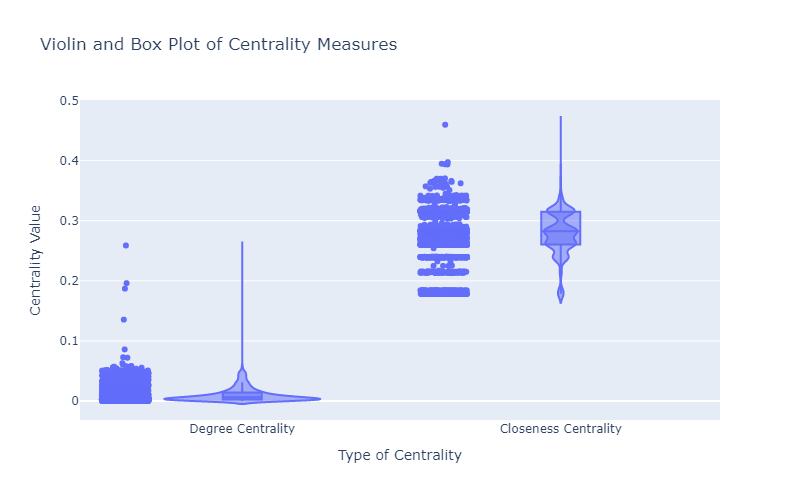

In [9]:
import plotly.express as px
df1 = pd.DataFrame({
    'Node': list(degree_centrality.keys()),
    'Degree Centrality': list(degree_centrality.values()),
})

df2 = pd.DataFrame({
    'Node': list(closeness_centrality.keys()),
    'Closeness Centrality': list(closeness_centrality.values())
})

df = pd.merge(left=df1, right=df2, on='Node')
# Melt the DataFrame to long format for violin plot
df_melted = df.melt(id_vars='Node', value_vars=['Degree Centrality', 'Closeness Centrality'], 
                    var_name='Centrality Type', value_name='Value')

# Create violin plot
fig = px.violin(
    df_melted, 
    x='Centrality Type', 
    y='Value', 
    box=True,
    points='all',
    title='Violin and Box Plot of Centrality Measures',
    labels={'Value': 'Centrality Value', 'Centrality Type': 'Type of Centrality'},
    width=800, 
    height=500
)

fig.show("png")

## Re-visualization of network graph

With this information we can re-visualize the network to emphasize central nodes. We use a new measure of centrality, betweeness centrality to highlight those nodes that are centrally located, on many central paths.
As is seen in the image below, a limited number of nodes are more centrally located in the networkw while many other nodes play a more peripheral role.

(-0.6526628029346465,
 0.7188801062107085,
 -1.185868907868862,
 0.9560496696829797)

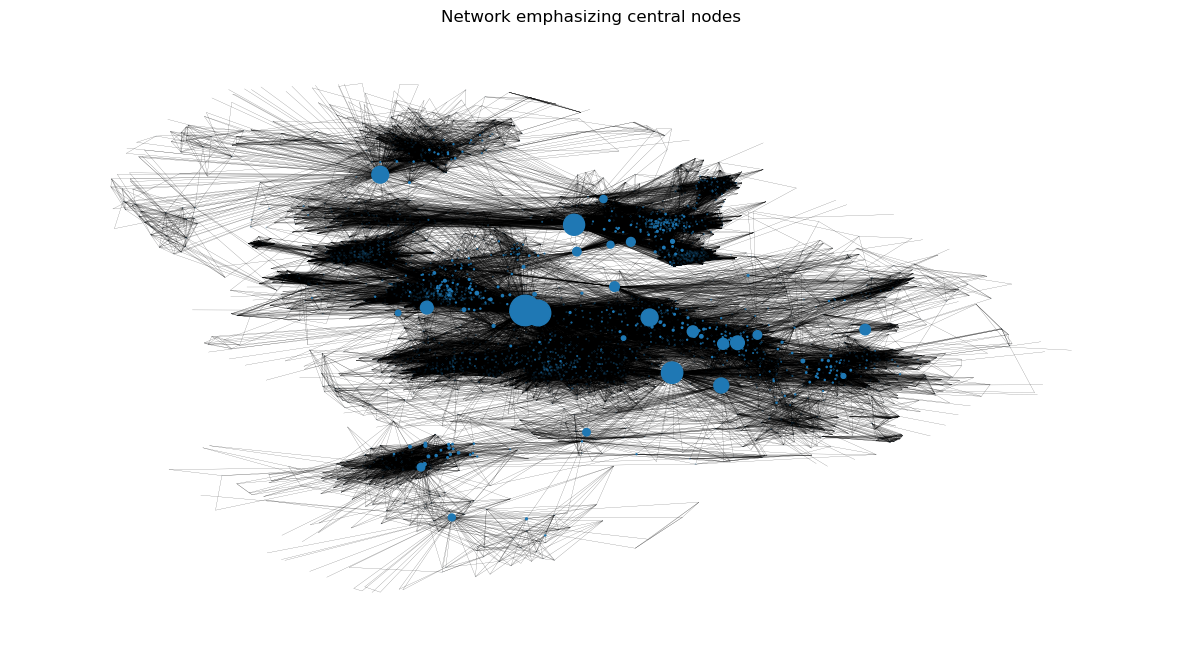

In [10]:
betweenness_centrality = nx.centrality.betweenness_centrality(
    G
)

node_size = [
    v * 1000 for v in betweenness_centrality.values()
]
plt.figure(figsize=(15, 8))
plt.title("Network emphasizing central nodes")
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.10)
plt.axis("off")

Given the above information and lastly, we can ask ourselves whether the nodes in the dataset form communities. A community is a group of nodes that are more closely connected to each other in the network than other nodes. The data reveals 16 communities or groupings of nodes using the Louvain algorithm.

In [11]:
from community import community_louvain

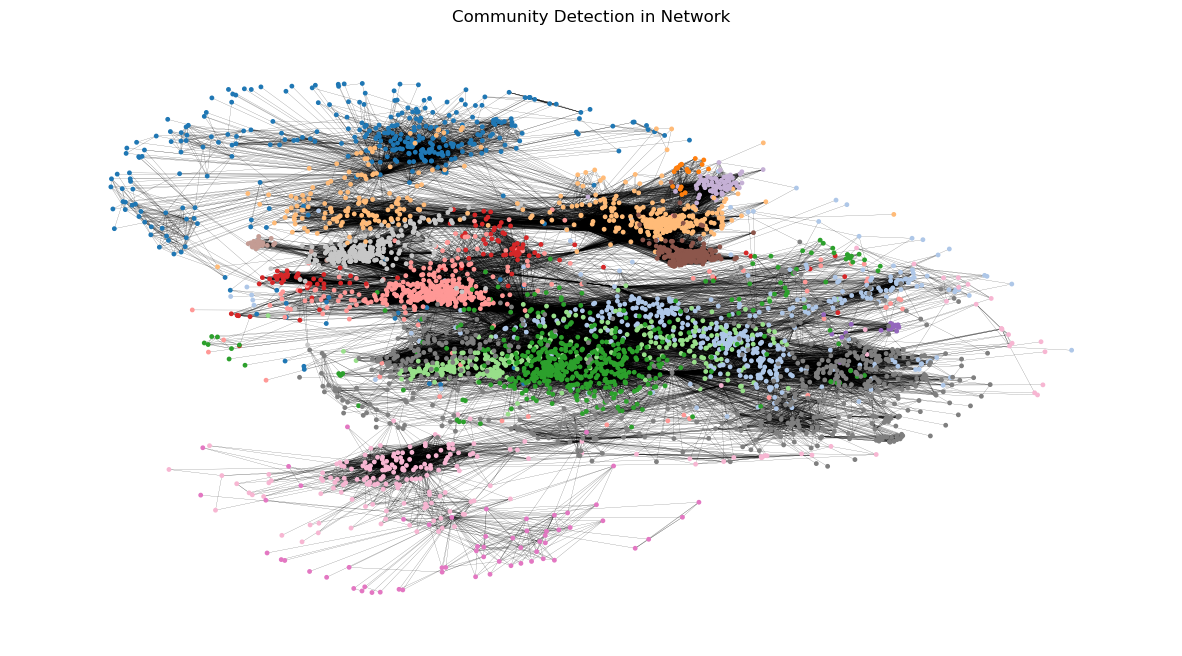

In [15]:
partition = community_louvain.best_partition(G)

# Get unique communities and assign colors
unique_communities = list(set(partition.values()))
community_colors = {comm: plt.cm.tab20(i) for i, comm in enumerate(unique_communities)}

# Map nodes to their community colors
node_colors = [community_colors[partition[node]] for node in G.nodes()]

# Draw the graph
plt.figure(figsize=(15, 8))
nx.draw_networkx(
    G,
    pos=pos,
    node_color=node_colors,
    with_labels=False,
    node_size=6,
    edge_color="black",
    width=0.10
)

plt.title("Community Detection in Network")
plt.axis("off")
plt.show()


In [13]:
len(community_colors)

16